In [1]:
import torch
import torchvision
import torch.nn as nn
import time
import copy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

print(torch.__version__)
print(torchvision.__version__)

2.3.0+cu121
0.18.0+cu121


In [2]:
def get_all_layers(model):
    """모든 leaf 레이어들을 순서대로 가져오기 - 경로와 함께"""
    all_layers = []
    
    def collect_leaves(module, prefix=''):
        for name, child in module.named_children():
            full_name = f"{prefix}.{name}" if prefix else name
            
            if len(list(child.children())) == 0:
                all_layers.append((full_name, child))
            else:
                collect_leaves(child, prefix=full_name)
    
    collect_leaves(model)
    return all_layers

In [3]:
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
from torchvision.models import mnasnet1_0, MNASNet1_0_Weights
from torchvision.models import googlenet, GoogLeNet_Weights
from torchvision.models import squeezenet1_0, SqueezeNet1_0_Weights

weights = SqueezeNet1_0_Weights.DEFAULT
model_squeezenet = squeezenet1_0(weights=weights)
model_squeezenet.eval()

weights = GoogLeNet_Weights.DEFAULT
model_googlenet = googlenet(weights=weights)
model_googlenet.eval()

weights = MobileNet_V2_Weights.DEFAULT
model_mobilenet = mobilenet_v2(weights=weights)
model_mobilenet.eval()


weights = MNASNet1_0_Weights.DEFAULT
model_mnasnet = mnasnet1_0(weights=weights)
model_mnasnet.eval()

models = {"squeezenet": model_squeezenet,
         "googlenet": model_googlenet,
         "mobilenet": model_mobilenet,
         "mnasnet": model_mnasnet}

models_original = copy.deepcopy(models)



for name, model in models.items():
    print(f"Model: {name}")
    print(f"Number of modules: {len(list(model.modules()))}")
    print(f"number of leaf layers: {len(get_all_layers(model))} ")
    print("-" * 40)


Model: squeezenet
Number of modules: 68
number of leaf layers: 57 
----------------------------------------
Model: googlenet
Number of modules: 224
number of leaf layers: 130 
----------------------------------------
Model: mobilenet
Number of modules: 213
number of leaf layers: 141 
----------------------------------------
Model: mnasnet
Number of modules: 182
number of leaf layers: 141 
----------------------------------------


In [22]:
class LaLaRAND:
    def __init__(self, model, device_sequence):
        self.model = model
        self.device_sequence = device_sequence
        self.current_device_index = 0
        self.all_layers = self._get_all_layers()
        self.execution_times = {}

        self._register_hooks()

        if len(self.device_sequence) != len(self.all_layers):
            raise ValueError("레이어 수와 device 결정 순서 개수가 일치하지 않음")
        
    def _get_all_layers(self):
        all_layers = []
        
        def recursive_children(module, parent=''):
            for name, child in module.named_children():
                if parent == False:
                    full_name = name
                else:
                    full_name = f"{parent}.{name}" 
                
                if len(list(child.children())) == 0:
                    all_layers.append((full_name, child))
                else:
                    recursive_children(child, parent=full_name)
        recursive_children(self.model)

        return all_layers
    
    def _register_hooks(self):
        for i, (layer_name, layer) in enumerate(self.all_layers):
            device_type = self.device_sequence[i]

            # Pre-hook: 레이어와 입력을 같은 device로 이동
            def make_pre_hook(idx, name, dev_type):
                def pre_hook(module, input):

                    input_memory_transfer_start_time = time.time()

                    # Target device 결정
                    if dev_type == 0:
                        target_device = 'cpu'
                    else:
                        target_device = 'cuda'  
                    
                    # 레이어를 target device로 이동
                    module.to(target_device)
                    
                    if isinstance(input, tuple):
                        result = []  # 튜플의 각 데이터들 위치 바꾸고 이 리스트에 저장(마지막에 다시 튜플로 변환)
                        for inp in input:
                            result.append(inp.to(target_device))  

                        return tuple(result)  
                    else: 
                        input = input.to(target_device)

                    input_memory_transfer_end_time = time.time()
                    input_memory_transfer_time = (input_memory_transfer_end_time - input_memory_transfer_start_time) * 1000  # ms로 변환
                    # 메모리 이동 시간 저장
                    device_name = "CPU" if dev_type == 0 else "GPU"
                    self.execution_times[f"Layer_{idx:03d}_{name}_input_memory_transfer"] = {'time_ms': input_memory_transfer_time, 
                                                                       'device': device_name}  
                    
                    module._start_time = time.time()  # 시작 시간 저장
                    return input
                
                
                return pre_hook
            
            # Post-hook: end_time 측정 및 output을 target_device로 이동
            def make_post_hook(idx, name, dev_type):
                def post_hook(module, input, output):

                    if torch.cuda.is_available():
                        torch.cuda.synchronize() 
                    else: 
                        None

                    module._end_time = time.time()  # 종료 시간 저장
                    execution_time = (module._end_time - module._start_time) * 1000  # ms로 변환
                    self.execution_times[f"Layer_{idx:03d}_{name}_execution_time"] = {'time_ms': execution_time, 
                                                                       'device': dev_type}
                    
                    output_memory_transfer_start_time = time.time()
                    # Target device 결정
                    if dev_type == 0:
                        target_device = 'cpu'
                    else:
                        target_device = 'cuda'
                    
                    output = output.to(target_device)

                    output_memory_transfer_end_time = time.time()
                    output_memory_transfer_time = (output_memory_transfer_end_time - output_memory_transfer_start_time) * 1000
                    
                    # 실행시간 저장
                    self.execution_times[f"Layer_{idx:03d}_{name}_output_memory_transfer"] = {'time_ms': output_memory_transfer_time, 
                                                                       'device': dev_type}

                    return output

                return post_hook
            
            # Hook 등록
            layer.register_forward_pre_hook(make_pre_hook(i, layer_name, device_type))
            layer.register_forward_hook(make_post_hook(i, layer_name, device_type))

    def forward(self, x):
        
        if self.device_sequence[0] == 0:
            first_device = 'cpu'
        else:
            first_device = 'cuda'

        x = x.to(first_device)
        
        self.model.eval()
        with torch.inference_mode():
            output = self.model(x)
            output = output.to("cuda") 
        
        return output
    


In [7]:
class LaLaRAND:
    def __init__(self, model, device_sequence):
        self.model = model
        self.device_sequence = device_sequence
        self.current_device_index = 0
        self.all_layers = self._get_all_layers()
        self.execution_times = {}

        self._register_hooks()

        if len(self.device_sequence) != len(self.all_layers):
            raise ValueError("레이어 수와 device 결정 순서 개수가 일치하지 않음")
        
    def _get_all_layers(self):
        all_layers = []
        
        def recursive_children(module, parent=''):
            for name, child in module.named_children():
                if parent == False:
                    full_name = name
                else:
                    full_name = f"{parent}.{name}" 
                
                if len(list(child.children())) == 0:
                    all_layers.append((full_name, child))
                else:
                    recursive_children(child, parent=full_name)
        recursive_children(self.model)

        return all_layers
    
    def _register_hooks(self):
        for i, (layer_name, layer) in enumerate(self.all_layers):
            device_type = self.device_sequence[i]

            # Pre-hook: 레이어와 입력을 같은 device로 이동 - 클로저 수정
            def make_pre_hook(idx, name, dev_type):
                def pre_hook(module, input):
                    if torch.cuda.is_available():
                        torch.cuda.synchronize() 

                    input_memory_transfer_start_time = time.time()

                    # Target device 결정
                    if dev_type == 0:
                        target_device = 'cpu'
                    else:
                        target_device = 'cuda'  
                    
                    # 레이어를 target device로 이동
                    module.to(target_device)
                    
                    if isinstance(input, tuple):
                        result = []
                        for inp in input:
                            result.append(inp.to(target_device))  
                        input = tuple(result)
                    else: 
                        input = input.to(target_device)

                    input_memory_transfer_end_time = time.time()
                    input_memory_transfer_time = (input_memory_transfer_end_time - input_memory_transfer_start_time) * 1000
                    
                    device_name = "CPU" if dev_type == 0 else "GPU"
                    self.execution_times[f"Layer_{idx:03d}_{name}_input_memory_transfer"] = {
                        'time_ms': input_memory_transfer_time, 
                        'device': device_name
                    }  
                    
                    module._start_time = time.time()  # 시작 시간 저장
                    return input
                
                return pre_hook
            
            # Post-hook: end_time 측정 및 output을 target_device로 이동 - 클로저 수정
            def make_post_hook(idx, name, dev_type):
                def post_hook(module, input, output):
                    if torch.cuda.is_available():
                        torch.cuda.synchronize() 

                    if hasattr(module, '_start_time'):
                        module._end_time = time.time()  
                        execution_time = (module._end_time - module._start_time) * 1000  
                        self.execution_times[f"Layer_{idx:03d}_{name}_execution_time"] = {
                            'time_ms': execution_time, 
                            'device': dev_type
                        }
                    
                    output_memory_transfer_start_time = time.time()

                    
                    output = output.to('cuda')

                    output_memory_transfer_end_time = time.time()
                    output_memory_transfer_time = (output_memory_transfer_end_time - output_memory_transfer_start_time) * 1000
                    
                    # 실행시간 저장
                    self.execution_times[f"Layer_{idx:03d}_{name}_output_memory_transfer"] = {
                        'time_ms': output_memory_transfer_time, 
                        'device': dev_type
                    }

                    return output

                return post_hook
            
            # Hook 등록 - 중요: 변수를 인자로 전달
            layer.register_forward_pre_hook(make_pre_hook(i, layer_name, device_type))
            layer.register_forward_hook(make_post_hook(i, layer_name, device_type))

    def forward(self, x):
        if self.device_sequence[0] == 0:
            first_device = 'cpu'
        else:
            first_device = 'cuda'

        x = x.to(first_device)
        
        self.model.eval()
        with torch.inference_mode():
            output = self.model(x)
            output = output.to("cuda") 
        
        return output

In [ ]:

from collections import defaultdict


for name, model in models.items():
    dummy_input = torch.randn(1000, 3, 224, 224).cuda()  # 1000개 배치

    # 레이어 수
    num_layers = len(get_all_layers(model))

    # 결과 저장
    comparison_result = defaultdict(dict)

    # 1️⃣ baseline: 모든 레이어 GPU
    gpu_config = [1] * num_layers
    gpu_model = LaLaRAND(copy.deepcopy(model), gpu_config)
    _ = gpu_model.forward(dummy_input)

    for key, value in gpu_model.execution_times.items():
        comparison_result[key]['gpu'] = value['time_ms']

    # 2️⃣ 레이어 하나씩 CPU로 옮겨 실험
    for i in range(num_layers):
        cpu_config = [1] * num_layers
        cpu_config[i] = 0  # i번째 레이어만 CPU

        cpu_model = LaLaRAND(copy.deepcopy(model), cpu_config)
        _ = cpu_model.forward(dummy_input)

        for key, value in cpu_model.execution_times.items():
            if f"Layer_{i:03d}_" in key:
                comparison_result[key]['cpu'] = value['time_ms']

    # 3️⃣ 결과 출력
    print(f"\n\n📊 Layer-wise CPU vs GPU Comparison for '{model.__class__.__name__}'")
    print("=" * 80)
    print(f"{'Layer':<35} {'GPU Time (ms)':<15} {'CPU Time (ms)':<15} {'Slowdown':<10}")
    print("-" * 80)

    for key, times in comparison_result.items():
        gpu_time = times.get('gpu', None)
        cpu_time = times.get('cpu', None)

        if gpu_time is not None and cpu_time is not None:
            slowdown = cpu_time / gpu_time if gpu_time > 0 else float('inf')
            print(f"{key:<35} {gpu_time:<15.3f} {cpu_time:<15.3f} {slowdown:<10.2f}")

    print("=" * 80)





📊 Layer-wise CPU vs GPU Comparison for 'SqueezeNet'
Layer                               GPU Time (ms)   CPU Time (ms)   Slowdown  
--------------------------------------------------------------------------------
Layer_000_.features.0_input_memory_transfer 0.227           0.037           0.16      
Layer_000_.features.0_execution_time 3.658           109.648         29.97     
Layer_000_.features.0_output_memory_transfer 0.005           69.165          13814.14  
Layer_001_.features.1_input_memory_transfer 0.013           315.082         24028.16  
Layer_001_.features.1_execution_time 1.085           34.689          31.98     
Layer_001_.features.1_output_memory_transfer 0.002           98.127          45730.56  
Layer_002_.features.2_input_memory_transfer 0.009           293.212         34161.64  
Layer_002_.features.2_execution_time 0.958           91.537          95.55     
Layer_002_.features.2_output_memory_transfer 0.003           17.142          6536.18   
Layer_003_.features.3

In [9]:

# 간단한 성능 분석 - 1000개 데이터를 한 배치로 처리
dummy_input = torch.randn(1000, 3, 224, 224).cuda()  # 1000개 배치

print("🚀 Simple LaLaRAND Performance Test")
print("=" * 50)

experiment_results = {}

for model_name, model in models.items():
    print(f"\n📊 {model_name.upper()}")
    print("-" * 30)
    
    num_layers = len(get_all_layers(model))
    
    # 1. 모든 레이어 GPU (베이스라인)
    baseline_config = [1] * num_layers
    baseline = LaLaRAND(copy.deepcopy(model), baseline_config)
    baseline_time = 0
    for _ in range(10):
        _ = baseline.forward(dummy_input) 

    baseline.execution_times.clear()  # 이전 실행 시간 초기화
    _ = baseline.forward(dummy_input)  # 1000개 배치를 한 번에 처리
    for key, value in baseline.execution_times.items():
        baseline_time += value['time_ms']
    print(f"All GPU (1000 batch): {baseline_time:.1f}ms")
    
    experiment_results[model_name] = {'baseline_time': baseline_time, 'layer_times': []}

    # 2. 각 레이어별 CPU 테스트 
    test_config = [1] * num_layers
    for layer_idx in range(num_layers):
        test_config[layer_idx] = 0  # 해당 레이어만 CPU

        cpu_controller = LaLaRAND(copy.deepcopy(model), test_config)
        
        cpu_time = 0
        _ = cpu_controller.forward(dummy_input)  # 1000개 배치를 한 번에 처리
        for value in cpu_controller.execution_times.values():
            cpu_time += value['time_ms']

        slowdown = cpu_time / baseline_time
        print(f"Layer {layer_idx:2d} CPU (1000 batch): {cpu_time:.1f}ms ({slowdown:.1f}x)")
        experiment_results[model_name]['layer_times'].append(cpu_time)

        test_config[layer_idx] = 1

print("\n✅ 완료!")

🚀 Simple LaLaRAND Performance Test

📊 SQUEEZENET
------------------------------
All GPU (1000 batch): 183.3ms
Layer  0 CPU (1000 batch): 1731.5ms (9.4x)
Layer  1 CPU (1000 batch): 3622.5ms (19.8x)
Layer  2 CPU (1000 batch): 3760.7ms (20.5x)
Layer  3 CPU (1000 batch): 1112.1ms (6.1x)
Layer  4 CPU (1000 batch): 332.1ms (1.8x)
Layer  5 CPU (1000 batch): 581.4ms (3.2x)
Layer  6 CPU (1000 batch): 764.2ms (4.2x)
Layer  7 CPU (1000 batch): 589.8ms (3.2x)
Layer  8 CPU (1000 batch): 767.4ms (4.2x)
Layer  9 CPU (1000 batch): 1379.0ms (7.5x)
Layer 10 CPU (1000 batch): 331.0ms (1.8x)
Layer 11 CPU (1000 batch): 584.2ms (3.2x)
Layer 12 CPU (1000 batch): 763.8ms (4.2x)
Layer 13 CPU (1000 batch): 577.2ms (3.1x)
Layer 14 CPU (1000 batch): 768.7ms (4.2x)
Layer 15 CPU (1000 batch): 1429.7ms (7.8x)
Layer 16 CPU (1000 batch): 476.6ms (2.6x)
Layer 17 CPU (1000 batch): 953.9ms (5.2x)
Layer 18 CPU (1000 batch): 1345.0ms (7.3x)
Layer 19 CPU (1000 batch): 980.9ms (5.4x)
Layer 20 CPU (1000 batch): 1347.5ms (7.4x

KeyboardInterrupt: 


📊 Visualizing experiment results...


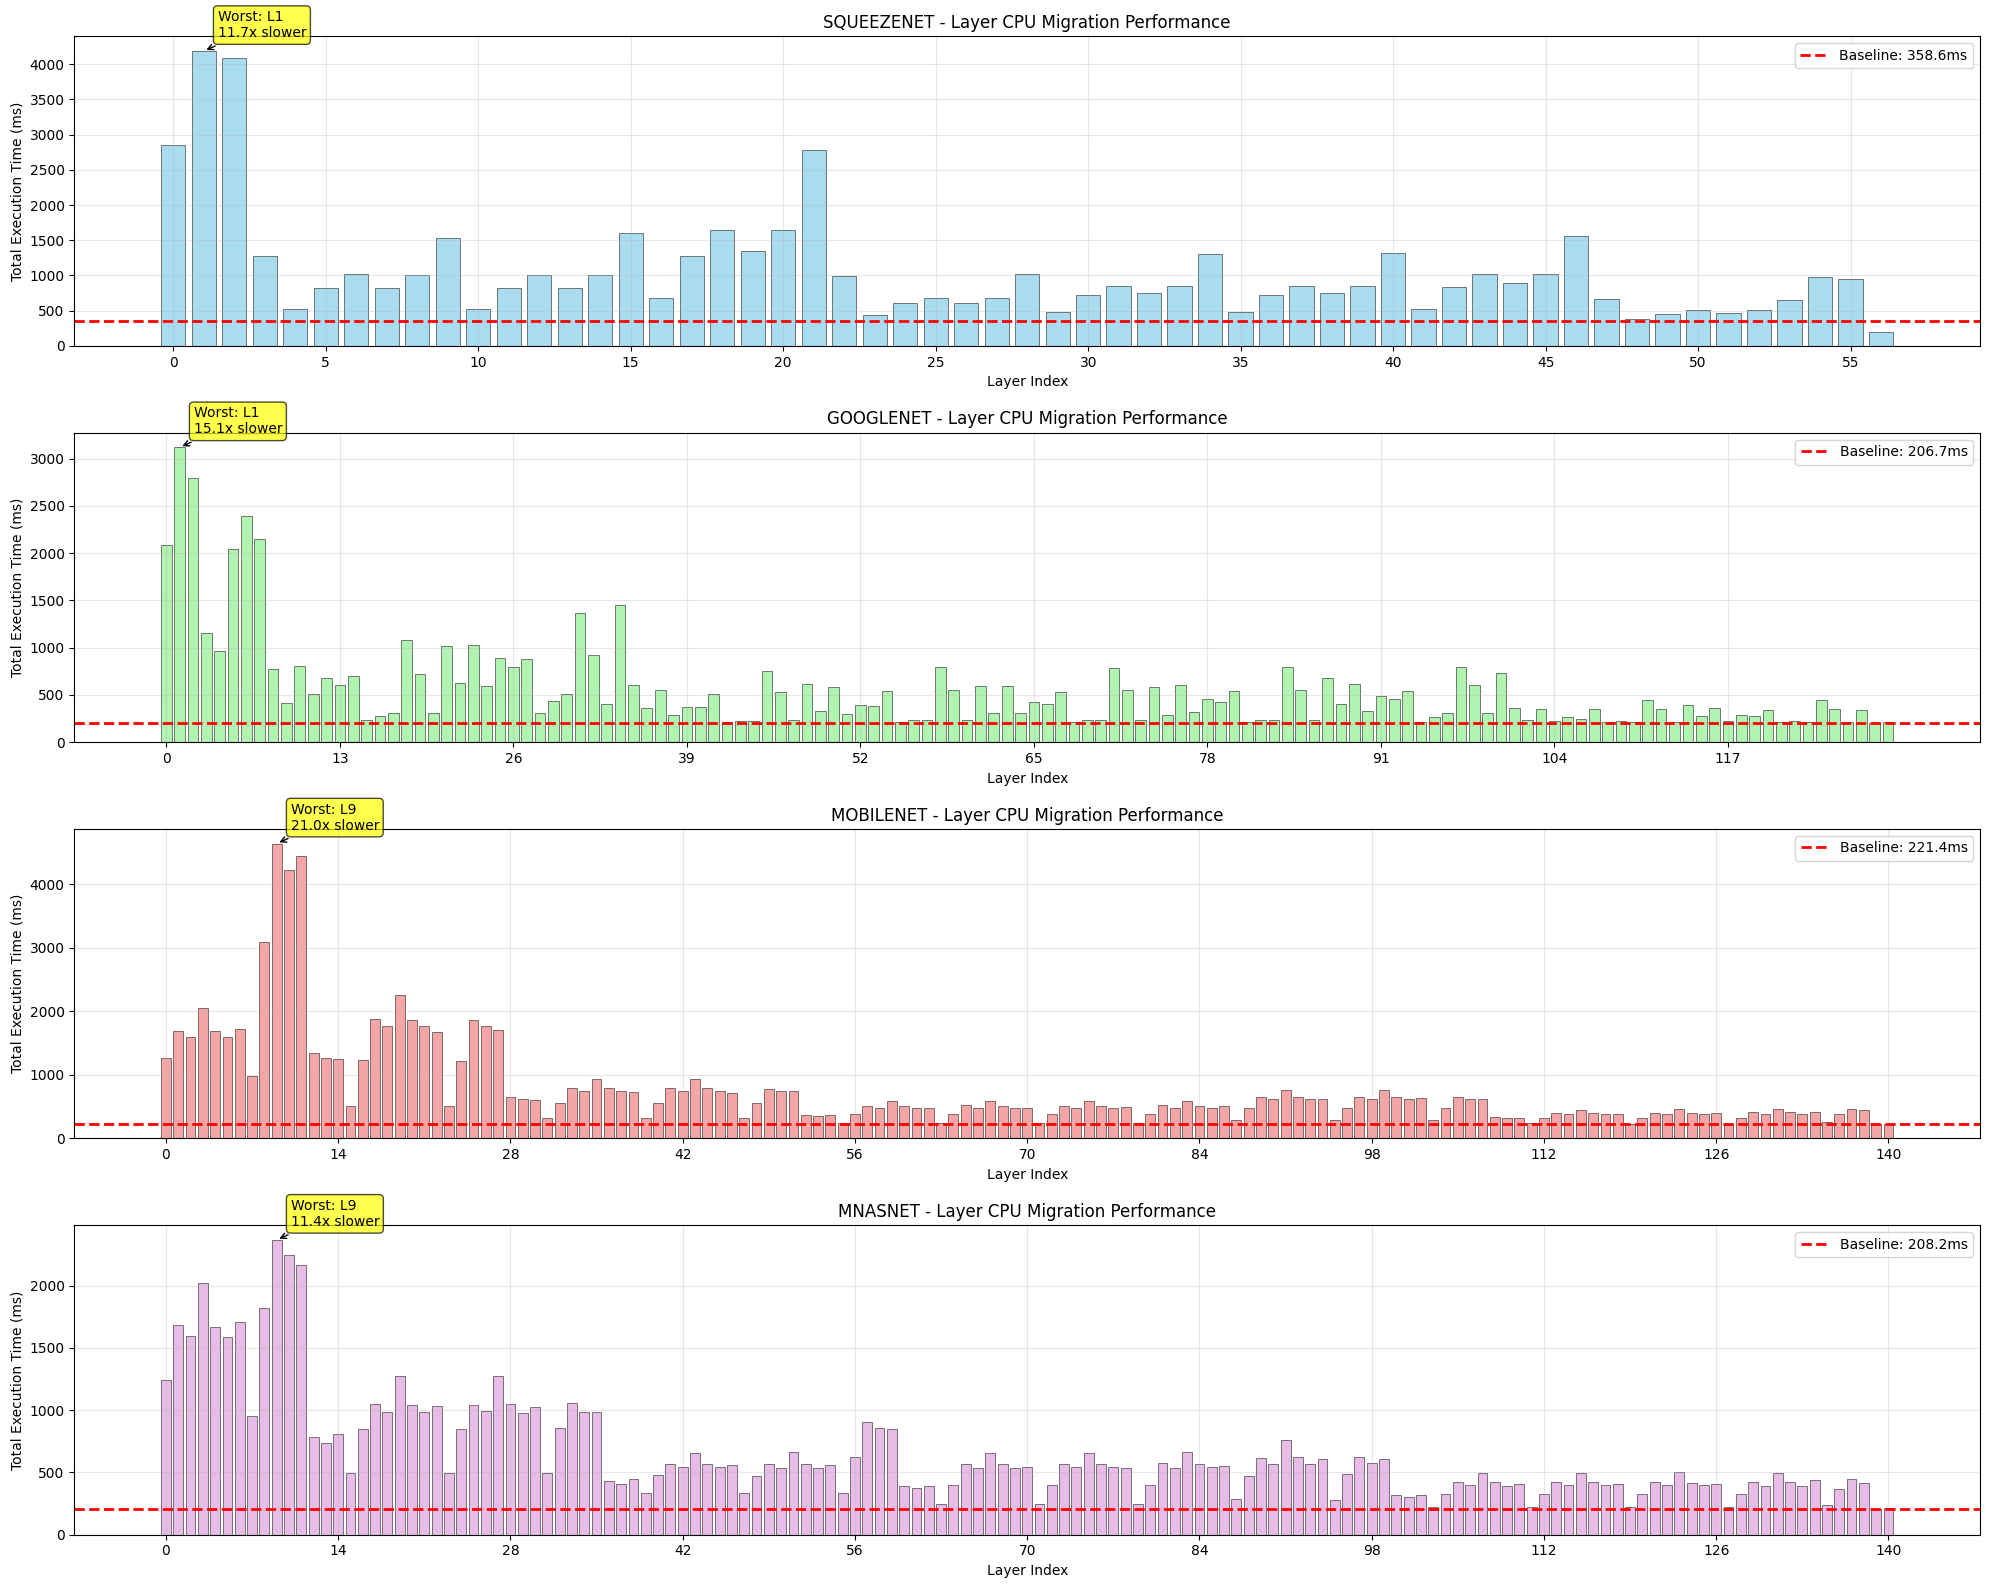

In [ ]:

import datetime
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

print("\n📊 Visualizing experiment results...")

# 시각화
fig, axes = plt.subplots(4, 1, figsize=(20, 16))
axes = axes.flatten()

colors = ['skyblue', 'lightgreen', 'lightcoral', 'plum']

for i, (model_name, data) in enumerate(experiment_results.items()):
    if i >= 4:
        break
    
    ax = axes[i]
    
    baseline_time = data['baseline_time']
    layer_times = data['layer_times']
    layer_indices = list(range(len(layer_times)))
    
    # 막대 그래프
    bars = ax.bar(layer_indices, layer_times, alpha=0.7, color=colors[i], 
                 edgecolor='black', linewidth=0.5)
    
    # 베이스라인을 빨간색 점선으로 표시
    ax.axhline(y=baseline_time, color='red', linestyle='--', 
              linewidth=2, label=f'Baseline: {baseline_time:.1f}ms')
    
    # 그래프 설정
    ax.set_xlabel('Layer Index')
    ax.set_ylabel('Total Execution Time (ms)')
    ax.set_title(f'{model_name.upper()} - Total Execution Performance')
    ax.set_xticks(layer_indices[::max(1, len(layer_indices)//10)])  # x축 라벨 간소화
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 가장 느린 레이어 표시
    max_time_idx = np.argmax(layer_times)
    max_time = layer_times[max_time_idx]
    slowdown = max_time / baseline_time
    
    ax.annotate(f'Worst: L{max_time_idx}\n{slowdown:.1f}x slower', 
               xy=(max_time_idx, max_time), 
               xytext=(10, 10), textcoords='offset points',
               bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
               arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

plt.tight_layout()
plt.savefig(f'/workspace/pytorch_bootcamp/results/experiment_results_comparison_{timestamp}.png', 
            dpi=300, bbox_inches='tight')
plt.show()
